In [1]:
!pip install transformers

In [22]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import logging
import matplotlib.pyplot as plt
import os
from datetime import datetime
logging.basicConfig(level=logging.ERROR)

In [3]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
%cd drive/MyDrive/Projects/trend_analysis

[Errno 2] No such file or directory: 'drive/MyDrive/Projects/trend_analysis'
/content/drive/MyDrive/Projects/trend_analysis/data


In [38]:
!ls

data


In [39]:
posts_df = pd.read_json("data/analyzed_trends.json")

In [9]:
posts_df.head()

,post,sentiment,label
0,Annonce ✨Vind smykker for i alt 10.000 kr.✨\n\...,positive,2
1,"reklame @ginatricot | Vil du hjælpe mig med, h...",positive,2
2,annonce | Mangler du et julegaveønske? 🫶\nLige...,positive,2
3,Vind 2x valgfrie smykker & 1x smykkeæske fra P...,positive,2
4,annonce Glædelig 3. søndag i advent! 🥰🎄✨\n\nI ...,positive,2


In [10]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual", truncation=True, do_lower_case=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [28]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.post
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        # Get the actual row using iloc to avoid index issues
        row = self.data.iloc[index]  # Use iloc to access by position
        text = str(row.post)
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(row.label, dtype=torch.float) # Access label from the row
        }

In [29]:
train, validate, test = np.split(
        posts_df.sample(frac=1, random_state=42),
        [int(0.8 * len(posts_df)), int(0.9 * len(posts_df))],
    )

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [30]:
print("Train, Validate, Test:",train.shape, validate.shape, test.shape)

Train, Validate, Test: (4142, 3) (518, 3) (518, 3)


In [31]:
training_set = SentimentData(train, tokenizer, MAX_LEN)
validation_set = SentimentData(validate, tokenizer, MAX_LEN)
test_set = SentimentData(test, tokenizer, MAX_LEN)
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 1
                }
valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 1
                }
test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 1
                }
training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **valid_params)
test_loader = DataLoader(test_set, **test_params)

In [17]:
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual")
model.to(device)

config.json:   0%|          | 0.00/982 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [34]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct
def one_epoch(model, data_loader, loss_fn, opt=None):
    """
    Runs one epoch of training or validation.

    Args:
        model: The model to be trained or evaluated.
        data_loader: DataLoader object that loads the batch of data.
        loss_fn: The loss function to optimize.
        opt: Optimizer for training phase (None during evaluation).

    Returns:
        avg_loss: Average loss over the epoch.
    """

    # Set the model to training or evaluation mode based on the optimizer
    train = False if opt is None else True
    model.train() if train else model.eval()
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0

    losses = []
    for _,data in enumerate(data_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        # Enable gradient computation only during training
        with torch.set_grad_enabled(train):
            outputs = model(ids, mask, token_type_ids).logits
        loss = loss_fn(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        if train:
            opt.zero_grad()  # Reset gradients
            loss.backward()  # Backpropagate gradients
            opt.step()  # Update model parameters
            # if scheduler:
            #     scheduler.step()

        losses.append(loss.item())

    avg_loss = np.mean(losses)
    print(f'The Total Accuracy for Epoch: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")
    return avg_loss

def train(
    model,
    train_loader,
    val_loader,
    lr=1e-3,
    max_epochs=3,
    patience=3,
):
    """
    Trains the model using the provided training and validation data loaders.

    Args:
        model: The neural network model to train.
        train_loader: DataLoader object for the training set.
        val_loader: DataLoader object for the validation set.
        lr: Learning rate for the optimizer. Default is 1e-3.
        max_epochs: Maximum number of epochs to train. Default is 30.
        weight_decay: Weight decay for L2 regularization. Default is 0.01.
        patience: Number of epochs with no improvement after which training will stop. Default is 3.
        custom_loss: Custom loss function (if needed). Default is None.

    Returns:
        train_losses: List of training losses per epoch.
        valid_losses: List of validation losses per epoch.
    """

    # Initialize the optimizer
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Add learning rate scheduler
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(
    #     opt,
    #     max_lr=lr,
    #     epochs=max_epochs,
    #     steps_per_epoch=len(train_loader),
    #     pct_start=0.3,  # Spend 30% of time warming up
    #     div_factor=25.0,  # Start with lr/25
    #     final_div_factor=1e4,  # End with lr/10000
    # )

    loss_fn = torch.nn.CrossEntropyLoss()
    best_valid_loss = float("inf")  # Initialize best validation loss
    patience_counter = 0  # Counter for early stopping
    train_losses, valid_losses = [], []  # Track losses for plotting/analysis

    # Training loop
    t = tqdm(range(max_epochs))
    for epoch in t:
        # Training phase
        train_loss = one_epoch(model, train_loader, loss_fn, opt)
        # Validation phase
        valid_loss = one_epoch(model, val_loader, loss_fn)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0  # Reset counter if validation loss improves
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch}")
                break

        t.set_description(f"train loss: {train_loss:.4f}, val loss: {valid_loss:.4f}")

    return train_losses, valid_losses

def plot_history(train_losses, valid_losses):
    """
    Plots the training and validation loss history over epochs.

    Args:
        train_losses: List of training losses for each epoch.
        valid_losses: List of validation losses for each epoch.
    """
    plt.figure(figsize=(7, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, label="train")
    plt.plot(valid_losses, label="valid")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

Begin training ...


  0%|          | 0/5 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.20849649608135223
Training Accuracy per 5000 steps: 87.5
The Total Accuracy for Epoch: 94.97827136648962
Training Loss Epoch: 0.1471782112566028
Training Accuracy Epoch: 94.97827136648962


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.0033059963025152683
Training Accuracy per 5000 steps: 100.0


train loss: 0.1472, val loss: 0.2644:  20%|██        | 1/5 [03:41<14:46, 221.58s/it]

The Total Accuracy for Epoch: 91.6988416988417
Training Loss Epoch: 0.2643762280824236
Training Accuracy Epoch: 91.6988416988417


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.00992458313703537
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch: 96.20956059874457
Training Loss Epoch: 0.11155731289047015
Training Accuracy Epoch: 96.20956059874457


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.0011426261626183987
Training Accuracy per 5000 steps: 100.0


train loss: 0.1116, val loss: 0.2621:  40%|████      | 2/5 [07:22<11:03, 221.26s/it]

The Total Accuracy for Epoch: 91.89189189189189
Training Loss Epoch: 0.2620571052745128
Training Accuracy Epoch: 91.89189189189189


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.008414089679718018
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch: 96.61999034282955
Training Loss Epoch: 0.09911806263212963
Training Accuracy Epoch: 96.61999034282955


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.003692375961691141
Training Accuracy per 5000 steps: 100.0


train loss: 0.0991, val loss: 0.2524:  60%|██████    | 3/5 [11:03<07:22, 221.23s/it]

The Total Accuracy for Epoch: 92.08494208494209
Training Loss Epoch: 0.2524171556059558
Training Accuracy Epoch: 92.08494208494209


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.011033846065402031
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch: 97.03042008691453
Training Loss Epoch: 0.08034629606853984
Training Accuracy Epoch: 97.03042008691453


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 1.312369704246521
Training Accuracy per 5000 steps: 75.0


train loss: 0.0803, val loss: 0.3009:  80%|████████  | 4/5 [14:44<03:41, 221.20s/it]

The Total Accuracy for Epoch: 92.66409266409266
Training Loss Epoch: 0.3009013762039383
Training Accuracy Epoch: 92.66409266409266


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.0032315393909811974
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch: 97.68227909222598
Training Loss Epoch: 0.06665887741714044
Training Accuracy Epoch: 97.68227909222598


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.004683507606387138
Training Accuracy per 5000 steps: 100.0


train loss: 0.0803, val loss: 0.3009:  80%|████████  | 4/5 [18:25<04:36, 276.49s/it]

The Total Accuracy for Epoch: 92.66409266409266
Training Loss Epoch: 0.2961059716583874
Training Accuracy Epoch: 92.66409266409266

Early stopping at epoch 4


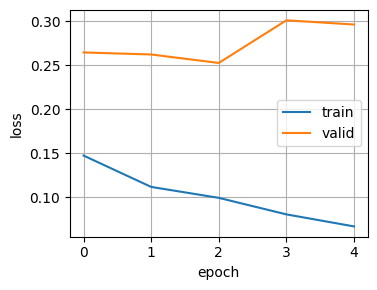

In [73]:
EPOCHS = 5
PATIENCE = 2

# Start the training process and plot the training history
print("Begin training ...")
plot_history(
    *train(
        model,
        training_loader,
        validation_loader,
        lr=LEARNING_RATE,
        max_epochs=EPOCHS,
        patience=PATIENCE,
    )
)



In [74]:
# Save the trained model and its hyperparameters
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
# Folder name to save the trained model
models_dir = "checkpoints"
os.makedirs(models_dir, exist_ok=True)

# Create model name with hyperparameters
model_name = "roberta_sentiment"

# Construct the path for saving the model
save_dir = os.path.join(models_dir, f"{timestamp}_{model_name}")
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "model.bin")
model.save_pretrained(save_dir)
# torch.save(model.state_dict(), model_path)
tokenizer.save_vocabulary(save_dir)
print("Model saved!")

Model saved!


In [55]:
!ls

checkpoints  data


In [75]:
test_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Projects/trend_analysis/checkpoints/20250331_2044_roberta_sentiment")
# checkpoint = torch.load("/content/drive/MyDrive/Projects/trend_analysis/checkpoints/20250331_1958_roberta_sentiment/model.bin", weights_only=False)
# test_model.load_state_dict(checkpoint)
test_model.eval()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [76]:
def evaluate_model(model, data_loader):
    n_correct = 0
    nb_tr_examples = 0
    all_predictions = []
    all_true_ratings = []

    with torch.no_grad():
      for _,data in enumerate(data_loader):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.long)

          outputs = model(ids, mask, token_type_ids).logits

          big_val, big_idx = torch.max(outputs.data, dim=1)
          n_correct += calcuate_accuracy(big_idx, targets)
          nb_tr_examples+=targets.size(0)


    accu_step = (n_correct*100)/nb_tr_examples

    return accu_step

In [79]:
test_model.to(device)
evaluate_model(test_model, test_loader)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


91.31274131274131

In [81]:
init_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual")
init_model.to(device)
init_model.eval()
print(evaluate_model(init_model, test_loader))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


63.12741312741313
